# Problem statement and background

Submission to the 2021 WIDS Datathon

The goal of this project is to predict the hourly energy usage or "load" for the 8 ERCOT regions of Texas for a 1 week period beginning midnight on Sunday, June 13 and ending at midnight on Saturday, June 20, 2021 (168 hourly values).  Electricity load forecasting is a time series problem and can be modeled using traditional time series forecasting methods (ie ARIMA or SARIMA), machine learning regression methods, or more advanced methods including neural networks. I tested various machine learning regression models and found that Extreme Gradient Boosting Regression (XGB_reg) models gave the best results.  

Below is Python code showing my data preparation, cross validation scheme, model testing, model tuning, and the final modeling and predictions.  

In [1]:
# importing libraries

import os, types
import io, requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

%matplotlib inline

# Data preparation

Features important for predicting electricity usage include past electricity usage and weather conditions since air conditioning demands drive electricity load flucuations. In this section, I import and clean historical electricity load data for the 8 ERCOT regions and historical weather data for 8 major cities located in those ERCOT regions. 

In [2]:
# import historical electricity load data

url = "https://raw.githubusercontent.com/WiDSTexas2021/datathon-code/main/data/ercot_hourly_load.csv"
s=requests.get(url).content
hr_load_raw =pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
hr_load_raw.head(3)

,Hour_Ending,Coast,East,Far West,North,North Central,South,South Central,West
0,2005-01-01 01:00:00-06:00,7507.810731,850.313988,998.465500,741.963778,7312.259820,1883.979457,3728.400885,692.294503
1,2005-01-01 02:00:00-06:00,7257.549136,818.143264,987.532852,711.996586,7012.466197,1798.234153,3562.614723,675.176013
2,2005-01-01 03:00:00-06:00,6973.987199,783.396624,978.575662,687.881144,6712.807281,1712.758395,3373.868049,659.650453


In [4]:
# helper function to prep electricity load data by filling in Nans, changing the "Hour_Ending" column to the 
# datetime format than making it the index

def prep_load_data(df):
    df.fillna(method='ffill', inplace=True)
    df["hour_ending"] =  df["Hour_Ending"].apply(lambda word: pd.to_datetime(word[:-6]))
    df = df.set_index("hour_ending")
    df = df[df.index.year >= 2008]
    df.drop(["Hour_Ending"], axis=1, inplace=True)
    return df

In [5]:
# use helper function to prepare the electrical load data

hr_load = prep_load_data(hr_load_raw)

In [6]:
hr_load.shape

(117864, 8)

In [7]:
hr_load.head(3)

,Coast,East,Far West,North,North Central,South,South Central,West
hour_ending,,,,,,,,
2008-01-01 00:00:00,7703.971900,1150.169930,1328.111170,1118.208380,11172.974700,1797.354000,4936.153800,960.910830
2008-01-01 01:00:00,7582.426275,1137.197278,1289.741591,1120.591245,10782.487804,1894.920943,4857.044340,932.251506
2008-01-01 02:00:00,7483.387277,1129.312429,1320.549720,1130.163920,10873.001190,1826.089194,4867.512567,939.958255


In [8]:
hr_load.describe()

,Coast,East,Far West,North,North Central,South,South Central,West
count,117864.000000,117864.000000,117864.000000,117864.000000,117864.000000,117864.000000,117864.000000,117864.000000
mean,11226.061007,1419.229797,2121.282829,859.714692,12873.694585,3191.410789,6432.273419,1118.596080
std,2684.421967,337.913383,866.633090,211.552647,3521.343338,836.897737,1740.376900,248.552425
min,1702.829343,737.857378,915.737194,488.272293,6302.601137,1459.085069,3334.911242,604.036851
25%,9304.100994,1182.198514,1383.928575,714.893877,10473.164785,2571.278059,5212.519389,939.062761
50%,10666.688366,1347.761271,1919.823615,803.719322,12011.587738,3030.730844,6012.172092,1073.211220
75%,12687.802083,1602.484219,2654.726286,961.392515,14650.743192,3701.534450,7350.020420,1255.551938
max,21256.115190,2949.198517,4636.980000,2258.092436,26499.240955,6192.252947,14166.701623,2564.305175


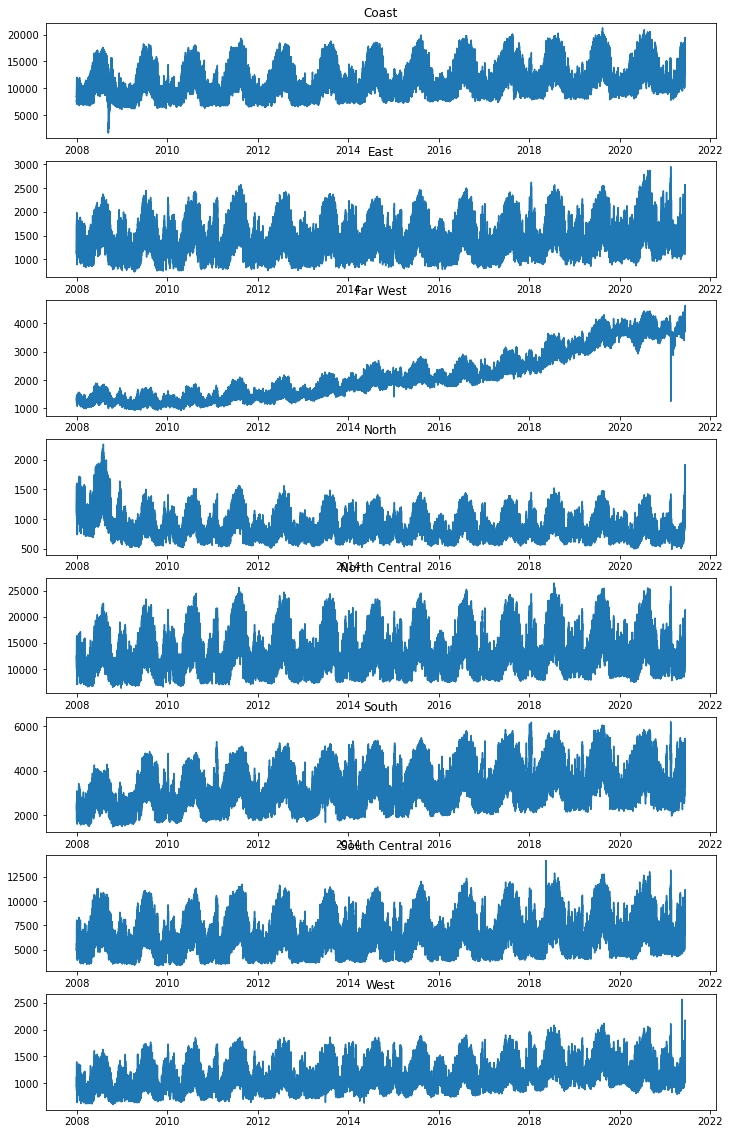

In [9]:
# visualize the raw electrical load data

regions = ["Coast", "East", "Far West", "North", "North Central", "South", "South Central", "West"]

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12,20))
for ax, region in zip(axes.flat, regions):
    ax.plot(hr_load.index, hr_load[region])
    ax.set_title(region)

### Comment on electricity load data
All the ERCOT regions show an annual periodicity and most show a slight trend up as time progresses.  This trend is especially pronounced in the Far West region.  Looking at the data on a smaller scale also shows a daily periodicity (plots not shown).

In [10]:
# import the historic weather data. Only import columns with metric measurements and those that are included in 
# the weather forecast data (which will be used to make predictions).  Omit some columns that seem less likely 
# to be useful. 

coi = ['date', 'time', 'city', 'tempC', 'windspeedKmph', 'weatherCode', 'precipMM', 'humidity',
      'visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC', 'WindGustKmph', 'FeelsLikeC', 'uvIndex']

url = "https://raw.githubusercontent.com/WiDSTexas2021/datathon-code/main/data/weather_history.csv"

s=requests.get(url).content
weather_his_raw =pd.read_csv(io.StringIO(s.decode('utf-8')), usecols=coi)

In [11]:
weather_his_raw.head()

,date,time,city,tempC,windspeedKmph,weatherCode,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindGustKmph,FeelsLikeC,uvIndex
0,2008-07-01,0,Abilene,21,7,113,0.0,63,10,1018,6,24,14,15,21,1
1,2008-07-01,0,Austin,25,9,176,0.6,61,9,1018,17,26,17,18,26,1
2,2008-07-01,0,Brownsville,26,8,113,0.0,86,10,1017,8,29,23,14,29,1
3,2008-07-01,0,Corpus Christi,26,12,113,0.0,83,10,1017,7,28,23,21,28,1
4,2008-07-01,0,Dallas,25,9,113,0.0,46,10,1018,4,25,12,18,25,1


<AxesSubplot:>

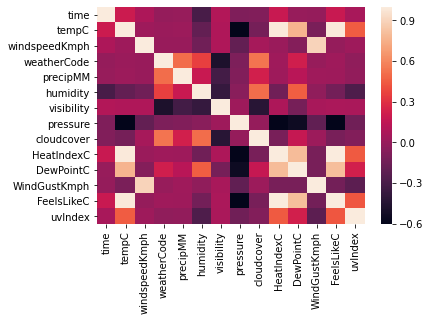

In [12]:
# look for correlation between weather features

weather_corr = weather_his_raw.corr()
sns.heatmap(weather_corr)

### Comment on the correlation plot:
The following features have the highest correlation:  HeatIndexC and tempC, FeelsLikeC and tempC, HeatIndexC and FeelsLikeC.  
The following features are also highly correlated: windspeedKmph and WindGustsKmph, HeatIndexC and DewPointC, FeelsLikeC and DewPointC, tempC and DewPointC. 

On the basis of these correlations, drop the following columns:  HeatIndexC, FeelsLikeC, WindGustKmph 

In [13]:
# helper function to prep historical weather data by filling in Nans, changing the "Hour_Ending" column to the 
# datetime format than making it the index, and dropping highly correlated columns

def prep_weather_data(df):
    df.loc[:, 'time'] = df.loc[:, 'time'].apply(lambda time: str(time).zfill(4))
    df["hour_ending"] = df["date"] + " " + df["time"]
    df["hour_ending"] = pd.to_datetime(df["hour_ending"], format="%Y-%m-%d %H%M")
    df.drop(['time', 'date', 'HeatIndexC', 'FeelsLikeC', 'WindGustKmph'], axis=1, inplace=True)
    df = df.set_index("hour_ending")
    df = df[df.index.year >= 2008]
    return df

In [14]:
# use helper function to prepare the historical weather data

weather_his = prep_weather_data(weather_his_raw)

In [15]:
weather_his.head(3)

,city,tempC,windspeedKmph,weatherCode,precipMM,humidity,visibility,pressure,cloudcover,DewPointC,uvIndex
hour_ending,,,,,,,,,,,
2008-07-01,Abilene,21,7,113,0.0,63,10,1018,6,14,1
2008-07-01,Austin,25,9,176,0.6,61,9,1018,17,17,1
2008-07-01,Brownsville,26,8,113,0.0,86,10,1017,8,23,1


In [16]:
# since this notebook specifically predicts electrical load for a specified week, limit downloaded data to that
# collected before the week begins 

start = '2009-01-01 00:00:00'
end = '2021-06-13 00:00:00'
weather_his_trunc = weather_his.truncate(before=start, after=end)
hr_load_trunc = hr_load.truncate(before=start, after=end)

### Comment on additional raw data initially explored

I originally included COVID cases as I was exploring models, but later feature importance tests showed that COVID cases were not important to the strongest models so I did not use that data in this demo notebook. 

## Create a feature dataframe for each ERCOT region

In [17]:
city_list = ['Abilene', 'Corpus Christi', 'Dallas', 'Houston', 'Midland', 'San Antonio', 'Tyler', 'Wichita Falls']
ercot_regions = ["West", "South", "North Central", "Coast", "Far West", "South Central", "East", "North" ]

In [18]:
# group weather data by city then create a dictionary where the keys are ERCOT regions and the the values
# are the grouped weather history for the coresponding city

region_df_dict = {}
weather_cities = weather_his_trunc.groupby("city")
for city, region in zip(city_list, ercot_regions):
    region_df_dict[region] = weather_cities.get_group(city)   

In [19]:
# the historical weather data is reported every 3 hours, resample so it is hourly

for key, df in region_df_dict.items():
    region_df_dict[key] = df.resample("1H").mean().ffill()    

In [20]:
region_df_dict["West"].head()

,tempC,windspeedKmph,weatherCode,precipMM,humidity,visibility,pressure,cloudcover,DewPointC,uvIndex
hour_ending,,,,,,,,,,
2009-01-01 00:00:00,4.0,12.0,113.0,0.0,46.0,10.0,1022.0,2.0,-6.0,1.0
2009-01-01 01:00:00,4.0,12.0,113.0,0.0,46.0,10.0,1022.0,2.0,-6.0,1.0
2009-01-01 02:00:00,4.0,12.0,113.0,0.0,46.0,10.0,1022.0,2.0,-6.0,1.0
2009-01-01 03:00:00,5.0,19.0,113.0,0.0,48.0,10.0,1020.0,0.0,-6.0,1.0
2009-01-01 04:00:00,5.0,19.0,113.0,0.0,48.0,10.0,1020.0,0.0,-6.0,1.0


In [21]:
# the weatherCode column contains 46 different codes. Place codes into 6 broad classes of like weather types. 
# Code to weather class relationships are defined in the dictionary below. 

# Weather code meanings came from this website: https://gist.github.com/dawnvoh/a1f513123f7b6a42577d

weather_dict = {113: "clear", 248: "cloudy", 122: "cloudy", 119: "cloudy", 116: "cloudy", 386: "light_rain", 
                353: "light_rain", 296: "light_rain", 293: "light_rain", 176: "light_rain", 143: "light_rain",
                389: "heavy_rain", 359: "heavy_rain", 356: "heavy_rain", 350: "heavy_rain", 308: "heavy_rain", 
                305: "heavy_rain", 302: "heavy_rain", 299: "heavy_rain", 200: "heavy_rain", 392: "light_winter_precip",
                374: "light_winter_precip", 368: "light_winter_precip", 362: "light_winter_precip", 326: "light_winter_precip",
                323: "light_winter_precip", 317: "light_winter_precip", 311: "light_winter_precip", 281: "light_winter_precip",
                266: "light_winter_precip", 263: "light_winter_precip", 260: "light_winter_precip", 185: "light_winter_precip",
                182: "light_winter_precip", 179: "light_winter_precip", 395: "heavy_winter_precip", 377: "heavy_winter_precip", 
                371: "heavy_winter_precip", 365: "heavy_winter_precip", 338: "heavy_winter_precip", 335: "heavy_winter_precip", 
                332: "heavy_winter_precip", 329: "heavy_winter_precip", 320: "heavy_winter_precip", 314: "heavy_winter_precip", 
                284: "heavy_winter_precip", 230: "heavy_winter_precip", 227: "heavy_winter_precip"}

In [22]:
# create a "weather_class" column that contains the class that corresponds with the given weather code

for region in ercot_regions:
    region_df_dict[region]["weather_class"] = region_df_dict[region]["weatherCode"].map(weather_dict)
    region_df_dict[region].drop("weatherCode", inplace=True, axis=1)

In [23]:
# add the electricy load data to the weather history dataframes 
# make all electricity load dataframes consistent by renamimg the column containing the load data "load"

column_rename_load = {"West": "load", "South": "load", "North Central": "load", "Coast": "load", "Far West": "load",
                 "South Central": "load", "East": "load", "North": "load"}

for region in ercot_regions:
    region_df_dict[region] = region_df_dict[region].join(hr_load_trunc[region], how='inner')
    region_df_dict[region] = region_df_dict[region].rename(columns=column_rename_load)

In [24]:
region_df_dict["West"].tail(3)

,tempC,windspeedKmph,precipMM,humidity,visibility,pressure,cloudcover,DewPointC,uvIndex,weather_class,load
hour_ending,,,,,,,,,,,
2021-06-11 19:00:00,37.0,27.0,0.0,25.0,10.0,1007.0,0.0,13.0,1.0,clear,1972.09
2021-06-11 20:00:00,37.0,27.0,0.0,25.0,10.0,1007.0,0.0,13.0,1.0,clear,1865.39
2021-06-11 21:00:00,35.0,22.0,0.0,36.0,10.0,1009.0,1.0,14.0,1.0,clear,1711.29


# Feature Engineering

In [25]:
# create date time features

for region in ercot_regions: 
    region_df_dict[region]['year'] = region_df_dict[region].index.year
    region_df_dict[region]['month'] = region_df_dict[region].index.month
    region_df_dict[region]["day_of_week"] = region_df_dict[region].index.weekday
    region_df_dict[region]["hour"] = region_df_dict[region].index.hour
    region_df_dict[region]["weekend"] = region_df_dict[region].loc[:, 'day_of_week'].apply(lambda x:  1 if x > 4 else 0)

In [26]:
# create a yearly lag feature 
# other lag featureas (ie daily or weekly) might be useful, but since our model needs to predict one week out,
# these values would not be available for the final predictions 

for region in ercot_regions:
    load = region_df_dict[region]["load"].copy()
    load_monthly = load.resample('M').mean()
    load_monthly_shift = load_monthly.shift(12)
    load_hourly_shift = load_monthly_shift.resample('1H').mean().ffill()
    region_df_dict[region] = region_df_dict[region].join(load_hourly_shift, how="left", rsuffix='year_lag')
    region_df_dict[region].dropna(inplace=True)
    

In [27]:
region_df_dict["West"].head(3)

,tempC,windspeedKmph,precipMM,humidity,visibility,pressure,cloudcover,DewPointC,uvIndex,weather_class,load,year,month,day_of_week,hour,weekend,loadyear_lag
hour_ending,,,,,,,,,,,,,,,,,
2010-01-31 00:00:00,-2.0,10.0,0.0,88.0,10.0,1025.0,0.0,-4.0,1.0,clear,1180.785920,2010,1,6,0,1,964.996235
2010-01-31 01:00:00,-2.0,10.0,0.0,88.0,10.0,1025.0,0.0,-4.0,1.0,clear,1204.901192,2010,1,6,1,1,964.996235
2010-01-31 02:00:00,-2.0,10.0,0.0,88.0,10.0,1025.0,0.0,-4.0,1.0,clear,1194.159860,2010,1,6,2,1,964.996235


In [28]:
region_df_dict["West"].shape

(99597, 17)

In [29]:
with open("data_covid_lag_dict.pickle", 'wb') as handle:
    pickle.dump(region_df_dict, handle)

NameError: name 'pickle' is not defined

# Modeling Testing

### The validation plan:

This model needs to forecast 1 week of electrical data accurately.  Unlike with tabular data, we cannot use cross validation to validate models since it is not appropriate to use future data to predict the past or present values.  Instead of cross validation, one option for time series forecasting is to use walk forward validation.  There are two ways to implement walk forward validation:  sliding window and expanding window. 

In sliding window walk forward validation, a training window of data at the beginning of the time series is specified followed by a test set.  A second window of training data is selected immediately following the first and again a second testing window following the second training window is set aside.  The training data is split up in this manner producing a predetermined number of k-folds.  The candidate models are trained on each training fold and used to make predictions for the following test folds.  An evaluation metric is calculated (I use RMSE here) for each fold and averaged. 

In expanding window walk forward validation, the principles are the similar except that the training folds are not exclusive.  The first training and testing folds are created as in the sliding window version, but when the second training fold is created, it is added to the data of the first training fold and so on.  Thus each training fold increases in size and the final fold contains most of the training data (except that set aside as testing data for the final fold).  Again candidate models are trained on each training fold and used to make predictions for the following test folds.  An evaluation metric is calculated for each fold and averaged. 

A good explanation of different validaton schemes for time series forecasting can be found here: 
https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

## Train - validation split

In [30]:
# for each region, set aside the last 4320 instances (24 * 180 - 6 months of data) to serve as the final validation 
# set for the "best" model.  The remainder of the data will be used to create training and testing sets.  Save in
# a dictionary with the structure "region": [train, validate]

train_val_dict = {}
for region in region_df_dict:
    df_list = []
    train = region_df_dict[region].iloc[:-4320, :]
    df_list.append(train)
    validate = region_df_dict[region].iloc[-4320:, :]
    df_list.append(validate)
    train_val_dict[region] = df_list

## Initial model testing

In [31]:
# standard scale numerical columns and one-hot encode categorical columns that include categories other than 0 and 1
# in preparation for model testing. 

num_columns = ['tempC', 'windspeedKmph', 'precipMM', 'humidity', 'visibility', 'pressure', 'cloudcover',
              'DewPointC', 'uvIndex', 'loadyear_lag']
cat_columns = ['weather_class', 'year', 'month', 'day_of_week', 'hour']
    
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'), cat_columns)], 
    remainder='passthrough')

data_prep_pipeline = Pipeline([
    ('col_preprocessing', col_preprocessing)],
    verbose=True)

In [32]:
# create a naive predictor model to serve as a null/baseline model.  It takes the last load value of the training 
# set and returns it as every predicted value. 
# code inspired by: https://towardsdatascience.com/build-your-own-custom-scikit-learn-regression-5d0d718f289

class NaivePredictor(RegressorMixin, BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y):
        X, y = check_X_y(X, y)  # checks X and y for consistent length, makes sure X is 2D and y is 1D, no nans in y
        
        self.target_ = y[-1]
        return self
    def predict(self, X):
        check_is_fitted(self)  # checks estimator is fitted by looking for fitted attributes (those with trailing underscores)
        X = check_array(X)  # makes X is non empty 2D array containing finite values,  
        return np.full(X.shape[0], self.target_)   
    
null_naive = NaivePredictor()

In [33]:
# regression models to try.  Early testing included SVM models but they preformed poorly and took a long time to 
# run so they were ommited from later rounds of testing.

lin_reg = LinearRegression()
SGD_reg = SGDRegressor()
ridge_reg = Ridge()
lasso_reg = Lasso()
EN_reg = ElasticNet()
DT_reg = DecisionTreeRegressor()
RF_reg = RandomForestRegressor(n_estimators=100)
GB_reg = GradientBoostingRegressor()
KN_reg = KNeighborsRegressor()
XGB_reg = XGBRegressor()
#SVM_reg = SVR()

all_model_name_list = ["null_naive", "lin_reg", "SGD_reg", "ridge_reg", "lasso_reg", 
                       "EN_reg", "DT_reg", "RF_reg", "GB_reg", "KN_reg", "XGB_reg"]

all_model_list = [null_naive, lin_reg, SGD_reg, ridge_reg, lasso_reg, 
                  EN_reg, DT_reg, RF_reg, GB_reg, KN_reg, XGB_reg]

In [34]:
train_val_dict["West"][0].shape

(95277, 17)

In [35]:
# this function implements a sliding window walk forward validation scheme with 4 folds then tests 
# the provided list of models.  It returns a dataframe with the columns "model", "k1_rmse", "k2_rmse", 
# "k3_rmse", "k4_rmse", "rmse_mean", "rmse_std". 

def time_series_model_testing_slide_wind(X_data, y_data, models, model_names):
    results_list = []   
    for name, model in zip(model_names, models):
        print("running with stepped window", name)
        length = X.shape[0]
        n_train_step = 19046
        n_test = 4320
        model_list = [name]
        rmse_list = []
        for i in range(n_train_step, length-n_train_step, n_train_step):
            X_train, X_test = X[i-n_train_step:i], X[i:i+4320]
            y_train, y_test = y[i-n_train_step:i], y[i:i+4320]
            #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            #print(rmse_list)
            rmse_list.append(rmse)
        model_list.extend(rmse_list)    
        model_list.append(np.mean(rmse_list))
        model_list.append(np.std(rmse_list))
        #print(model_list)
        results_list.append(model_list)
    df = pd.DataFrame(results_list, columns=["model", "k1_rmse", "k2_rmse", "k3_rmse", "k4_rmse", "rmse_mean", "rmse_std"])  
    return df

In [36]:
# this function implements a expanding window walk forward validation scheme with 4 folds then tests 
# the provided list of models.  It returns a dataframe with the columns "model", "k1_rmse", "k2_rmse", 
# "k3_rmse", "k4_rmse", "rmse_mean", "rmse_std". 

def time_series_model_testing_exp_wind(X_data, y_data, models, model_names):
    results_list = []   
    for name, model in zip(model_names, models):
        print("running with exp window", name)
        length = X.shape[0]
        n_train_step = 19046
        n_test = 4320
        model_list = [name]
        rmse_list = []
        for i in range(n_train_step, length-n_train_step, n_train_step):
            X_train, X_test = X[0:i], X[i:i+4320]
            y_train, y_test = y[0:i], y[i:i+4320]
            #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            #print(rmse_list)
            rmse_list.append(rmse)
        model_list.extend(rmse_list)    
        model_list.append(np.mean(rmse_list))
        model_list.append(np.std(rmse_list))
        #print(model_list)
        results_list.append(model_list)
    df = pd.DataFrame(results_list, columns=["model", "k1_rmse", "k2_rmse", "k3_rmse", "k4_rmse", "rmse_mean", "rmse_std"])  
    return df

In [37]:
# use the expanding and sliding/step window walk forward validation schemes to test a list of regression models
# assemble results in a dataframe for comparison purposes

results = {}
for region in train_val_dict:
    print(region)
    y = train_val_dict[region][0].loc[:, 'load']
    X_train = train_val_dict[region][0].drop(["load"], axis=1)
    #print(y.shape, X_train.shape)
    X = data_prep_pipeline.fit_transform(X_train.copy())
    #print(X.shape, y.shape)
    step_results = time_series_model_testing_slide_wind(X, y, all_model_list, all_model_name_list)
    exp_results = time_series_model_testing_exp_wind(X, y, all_model_list, all_model_name_list)
    compare = pd.concat([step_results["model"], step_results["rmse_mean"], exp_results["rmse_mean"]], axis=1)
    compare.columns = ['model', 'slide_rmse', 'exp_rmse']
    results[region] = [compare, step_results, exp_results] 

West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with stepped window null_naive
running with stepped window lin_reg
running with stepped window SGD_reg
running with stepped window ridge_reg
running with stepped window lasso_reg
running with stepped window EN_reg
running with stepped window DT_reg
running with stepped window RF_reg
running with stepped window GB_reg
running with stepped window KN_reg
running with stepped window XGB_reg
running with exp window null_naive
running with exp window lin_reg
running with exp window SGD_reg
running with exp window ridge_reg
running with exp window lasso_reg
running with exp window EN_reg
running with exp window DT_reg
running with exp window RF_reg
running with exp window GB_reg
running with exp window KN_reg
running with exp window XGB_reg
South
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
running with stepped window null_naive
running with stepped window lin_reg
running with stepped

In [41]:
# print results for comparison purposes

for region in ercot_regions:
    print(region)
    print(results[region][0])
    print()

West
         model    slide_rmse      exp_rmse
0   null_naive  3.993082e+02  3.993082e+02
1      lin_reg  8.527186e+12  7.932786e+12
2      SGD_reg  1.846944e+02  1.764321e+02
3    ridge_reg  1.576376e+02  1.639569e+02
4    lasso_reg  1.630241e+02  1.602941e+02
5       EN_reg  1.925530e+02  1.950647e+02
6       DT_reg  1.275855e+02  1.291820e+02
7       RF_reg  9.513341e+01  9.824132e+01
8       GB_reg  9.674733e+01  1.001772e+02
9       KN_reg  1.218122e+02  1.250693e+02
10     XGB_reg  9.087625e+01  9.131505e+01

South
         model    slide_rmse      exp_rmse
0   null_naive  1.117400e+03  1.117400e+03
1      lin_reg  2.084163e+14  7.949351e+12
2      SGD_reg  4.808780e+02  4.568995e+02
3    ridge_reg  4.412018e+02  4.366735e+02
4    lasso_reg  4.433421e+02  4.336795e+02
5       EN_reg  5.837351e+02  5.753925e+02
6       DT_reg  3.678608e+02  3.752068e+02
7       RF_reg  2.876084e+02  2.852903e+02
8       GB_reg  2.624670e+02  2.808797e+02
9       KN_reg  3.613998e+02  3.534805e+02

### Comment on initial model testing results:

All models tested outperformed the null naive model.  None of the linear regression models performed well. The tree based models had the best performance with the XGB_reg ensemble model doing especially well for most ERCOT regions. The XGB_reg model with either the expanded or stepwise validation scheme was the first or second model in 7 out of 8 regions and the 3rd best model in the final region. 

## Feature Importance

In [42]:
# Look at the top 30 features for each regional model

features = ['tempC', 'windspeedKmph', 'precipMM', 'humidity', 'visibility', 'pressure', 'cloudcover',
              'DewPointC', 'uvIndex', 'loadyear_lag', 'weather_class', 'weather_class', 'weather_class',
                'weather_class', 'weather_class', 'weather_class', 'year1', 'year2', 'year3', 'year4', 'year5', 
                'year6', 'year7', 'year8', 'year9', 'year10', 'year11', 'month1', 'month2', 'month3', 'month4', 
                'month5', 'month6', 'month7', 'month8', 'month9', 'month10', 'month11', 'month12', 'day_of_week1', 
                'day_of_week2', 'day_of_week3', 'day_of_week4', 'day_of_week5', 'day_of_week6', 'day_of_week7', 
                'hour1', 'hour2', 'hour3', 'hour4', 'hour5', 'hour6', 'hour7', 'hour8', 'hour9', 'hour10', 'hour11',
                'hour12', 'hour13', 'hour14', 'hour15', 'hour16', 'hour17', 'hour18', 'hour19', 'hour20', 'hour21', 
                'hour22', 'hour23', 'hour24', 'weekend']

for region in ercot_regions:
    print(region)
    train = train_val_dict[region][0].iloc[:-360, :]
    test = train_val_dict[region][0].iloc[-360:, :]
    y = train.loc[:, 'load']
    X_train = train.drop(["load"], axis=1)
    print(y.shape, X_train.shape)
    X = data_prep_pipeline.fit_transform(X_train.copy())
    XGB_reg.fit(X, y)
    feat_import = XGB_reg.feature_importances_
    feat_import_df = pd.DataFrame(feat_import, index=features, columns=["importance"])
    print(feat_import_df.sort_values("importance", ascending=False).head(30))

West
(94917,) (94917, 16)
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
               importance
tempC            0.106875
hour22           0.068103
hour23           0.056256
hour3            0.055501
year10           0.054944
hour5            0.054410
hour6            0.051127
hour4            0.049378
hour2            0.041493
hour7            0.039093
year9            0.038428
year2            0.027700
hour20           0.024373
month12          0.020315
loadyear_lag     0.018001
uvIndex          0.017790
hour10           0.017127
hour13           0.015402
year8            0.014000
hour8            0.012748
hour19           0.012355
weekend          0.011511
year1            0.010450
hour14           0.009871
hour21           0.009690
year11           0.009599
hour1            0.009394
year4            0.009304
weather_class    0.008960
hour11           0.008854
South
(94917,) (94917, 16)
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s

In [43]:
# Look at the bottom 30 features for each regional model

for region in ercot_regions:
    print(region)
    train = train_val_dict[region][0].iloc[:-360, :]
    test = train_val_dict[region][0].iloc[-360:, :]
    y = train.loc[:, 'load']
    X_train = train.drop(["load"], axis=1)
    print(y.shape, X_train.shape)
    X = data_prep_pipeline.fit_transform(X_train.copy())
    XGB_reg.fit(X, y)
    feat_import = XGB_reg.feature_importances_
    feat_import_df = pd.DataFrame(feat_import, index=features, columns=["importance"])
    print(feat_import_df.sort_values("importance", ascending=True).head(30))

West
(94917,) (94917, 16)
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
               importance
visibility       0.000560
day_of_week6     0.000603
weather_class    0.000771
day_of_week4     0.000795
day_of_week2     0.000817
weather_class    0.000831
weather_class    0.000853
day_of_week5     0.000903
humidity         0.000934
precipMM         0.000968
day_of_week1     0.001004
cloudcover       0.001006
windspeedKmph    0.001071
day_of_week3     0.001079
hour16           0.001248
weather_class    0.001369
month9           0.001397
weather_class    0.001404
month7           0.001509
year6            0.001889
month8           0.002061
day_of_week7     0.002406
hour15           0.002718
year7            0.002833
month5           0.002848
pressure         0.002889
month11          0.003196
hour24           0.003245
year5            0.003340
DewPointC        0.003552
South
(94917,) (94917, 16)
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s

### Comment on feature importance results

After looking at the top 30 features for each model, a few things stand out.  First tempC is the most important feature for all the models except one.  Also common in the top feature lists are hour categories, year categories, loadyear_lag, and month categories.  UVIndex, weekend, and DewPointC also are in the top 30 for some models.  In the bottom 30 features, weather_class categories and day_of_week categories are the least useful along with the weather related numbers such as windspeedKmph, visability, humidity, pressure, and cloudcover.  I'm going to remove these less useful features and see if XGB_reg model performance improves. 

In [44]:
# remove less important features from the original feature sets.  Save smaller feature sets in a dictionay keyed by
# region. 

region_small_df_dict = {}
for region in ercot_regions:
    region_small_df_dict[region] = region_df_dict[region].drop(['weather_class', "day_of_week", "precipMM", 
                                                               "windspeedKmph", "visibility", "humidity", 
                                                                "cloudcover", 'pressure'], axis=1)    

In [45]:
# redo the training and validation split for the smaller feature set

small_train_val_dict = {}
for region in region_small_df_dict:
    df_list = []
    train = region_small_df_dict[region].iloc[:-4320, :]
    df_list.append(train)
    validate = region_small_df_dict[region].iloc[-4320:, :]
    df_list.append(validate)
    small_train_val_dict[region] = df_list

In [46]:
# standard scale numerical columns and one-hot encode categorical columns that include categories other than 0 and 1
# in preparation for model testing.  Pipeline for the small feature set.

small_num_columns = ['tempC','DewPointC', 'uvIndex', 'loadyear_lag']
small_cat_columns = ['year', 'month', 'hour']
    
small_col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), small_num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), small_cat_columns)], 
    remainder='passthrough')

data_prep_small_pipeline = Pipeline([
    ('col_preprocessing', small_col_preprocessing)],
    verbose=True)

In [47]:
# use the expanding and sliding window walk forward validation schemes to test XGB_reg model on the smaller 
# feature set then assemble results in a dataframe for comparison purposes. 

results = {}
for region in small_train_val_dict:
    print(region)
    y = small_train_val_dict[region][0].loc[:, 'load']
    X_train = small_train_val_dict[region][0].drop(["load"], axis=1)
    #print(y.shape, X_train.shape)
    X = data_prep_small_pipeline.fit_transform(X_train.copy())
    #print(X.shape, y.shape)
    step_results = time_series_model_testing_slide_wind(X, y, [XGB_reg], ["XGB_reg"])
    exp_results = time_series_model_testing_exp_wind(X, y, [XGB_reg], ["XGB_reg"])
    compare = pd.concat([step_results["model"], step_results["rmse_mean"], exp_results["rmse_mean"]], axis=1)
    compare.columns = ['model', 'step_rmse', 'exp_rmse']
    results[region] = [compare, step_results, exp_results] 

West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with stepped window XGB_reg
running with exp window XGB_reg
South
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with stepped window XGB_reg
running with exp window XGB_reg
North Central
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with stepped window XGB_reg
running with exp window XGB_reg
Coast
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with stepped window XGB_reg
running with exp window XGB_reg
Far West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with stepped window XGB_reg
running with exp window XGB_reg
South Central
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with stepped window XGB_reg
running with exp window XGB_reg
East
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with stepped window XGB_reg


In [48]:
# print results for comparison purposes 

for region in ercot_regions:
    print(region)
    print(results[region][0])
    print()

West
     model  step_rmse   exp_rmse
0  XGB_reg  93.523097  93.498087

South
     model   step_rmse    exp_rmse
0  XGB_reg  245.662772  256.474008

North Central
     model    step_rmse     exp_rmse
0  XGB_reg  1078.398751  1040.031239

Coast
     model   step_rmse   exp_rmse
0  XGB_reg  878.856181  903.93547

Far West
     model   step_rmse   exp_rmse
0  XGB_reg  240.331971  257.65013

South Central
     model   step_rmse    exp_rmse
0  XGB_reg  548.057612  534.121607

East
     model   step_rmse    exp_rmse
0  XGB_reg  113.987486  105.951287

North
     model  step_rmse   exp_rmse
0  XGB_reg  59.655874  58.254165



### Comments on XGB_reg using the smaller feature set

After comparing this recent result with the original model testing results, the mean RMSEs of the expanding window tests shows that all of the regions' mean RMSE is lower (better) when the larger dataset is used. Proceed using the larger dataset. 

# Hyperparameter Optimization

The XGB_reg model parameters will be tuned using an AutoML Tuner, HyperOpt. 

Code snippets for setting up HyperOpt and its parameters from https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9 and 
https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [ ]:
# initalize the domain space

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'gamma': hp.uniform ('gamma', 1, 9),
       'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
# define the objective function

def hyperparameter_tuning(space):
    model=XGBRegressor(n_estimators=space['n_estimators'], max_depth=int(space['max_depth']), gamma=space['gamma'],
                         reg_alpha=int(space['reg_alpha']), min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    
    evaluation = [(X_validate, y_validate)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)

    pred = model.predict(X_validate)
    mse = mean_squared_error(y_validate, pred)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}   

In [ ]:
# tune all regions

large_tuning_results = {}
for region in ercot_regions:
    print(region)
    data = train_val_dict[region][0]
    data_X = data.drop(["load"], axis=1)
    y = data.loc[:, 'load']
    X = data_prep_pipeline.fit_transform(data_X.copy())
    X_train = X[:-4320]
    X_validate = X[-4320:]
    y_train = y[:-4320]
    y_validate = y[-4320:]
    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)
    large_tuning_results[region] = best


In [ ]:
large_tuning_results

In [51]:
# dictionary of XGB_reg models with the tuned hyperparameters specific to each region

opt_XGB_reg = {"West": XGBRegressor(colsample_bytree=0.7274177109461611,
  gamma=6.109037711661932, max_depth=8, min_child_weight=7, reg_alpha=77,
  reg_lambda=0.7411131263811439), 
  'South': XGBRegressor(colsample_bytree=0.8807697826784431,
  gamma=7.622094005671151, max_depth=4, min_child_weight=6, reg_alpha=55,
  reg_lambda=0.8646601679667565),
  'North Central': XGBRegressor(colsample_bytree=0.8321988823431581,
  gamma=8.972661538506525, max_depth=5, min_child_weight=8, reg_alpha=147,
  reg_lambda=0.8597622130820659),
  'Coast': XGBRegressor(colsample_bytree=0.8037745842635384,
  gamma=2.5019634695680484, max_depth=4, min_child_weight=10, reg_alpha=152, 
  reg_lambda=0.47819270061391045),
  'Far West': XGBRegressor(colsample_bytree=0.8808916212036829,
  gamma=3.8061263263320435, max_depth=9, min_child_weight=0,
  reg_alpha=86, reg_lambda=0.37433909282607963),
  'South Central': XGBRegressor(colsample_bytree=0.9214407455437166,
  gamma=7.0287687769057525, max_depth=5, min_child_weight=0,
  reg_alpha=173, reg_lambda=0.47465511546868056),
  'East': XGBRegressor(colsample_bytree=0.5726099997759762,
  gamma=1.1464658737314208, max_depth=5, min_child_weight=1,
  reg_alpha=92, reg_lambda=0.7280653035524614),
  'North': XGBRegressor(colsample_bytree=0.8208201441078663,
  gamma=4.841409685512929, max_depth=16, min_child_weight=3,
  reg_alpha=146, reg_lambda=0.00956097020153629)}

In [62]:
# test the optimized parameters to see how they perform compared to the default paraments

XGB_reg = XGBRegressor()
for region in ercot_regions:    
    print(region)
    data = train_val_dict[region][0]
    data_X = data.drop(["load"], axis=1)
    y = data.loc[:, 'load']
    X = data_prep_pipeline.fit_transform(data_X.copy())
    XGB_reg_df = time_series_model_testing_exp_wind(X, y, [XGB_reg], ["XGB_reg"])
    print("default hyperparameters")
    print(XGB_reg_df)
    opt_XGB_reg_df = time_series_model_testing_exp_wind(X, y, [opt_XGB_reg[region]], ["region"])
    print("optimized hyperparameters")
    print(opt_XGB_reg_df)
    print()

West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
running with exp window XGB_reg
default hyperparameters
     model    k1_rmse   k2_rmse    k3_rmse     k4_rmse  rmse_mean   rmse_std
0  XGB_reg  75.061275  73.80772  80.565928  135.825275   91.31505  25.823418
running with exp window region
optimized hyperparameters
    model    k1_rmse    k2_rmse    k3_rmse     k4_rmse  rmse_mean   rmse_std
0  region  71.898669  78.452365  81.804037  130.508929     90.666  23.277559

South
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
running with exp window XGB_reg
default hyperparameters
     model     k1_rmse     k2_rmse     k3_rmse     k4_rmse  rmse_mean  \
0  XGB_reg  232.467762  205.653469  237.206497  319.212113  248.63496   

    rmse_std  
0  42.486854  
running with exp window region
optimized hyperparameters
    model     k1_rmse     k2_rmse     k3_rmse     k4_rmse   rmse_mean  \
0  region  236.142523  207.507982  226.933394  306.313926  244

### Comments on hyperparameter tuning

Hyper parameter optimization did not result in large gains in model performance though 6 of the 8 models did show decreased mean RMSE. The optimized parameters identified above will be used for the West, South, North Central, Coast, Far West, and South Central regions.  The default parameters will be used for East and North regions. 

# Final training of selected models and testing of validation data

In [63]:
# dictionary of final XGB_regression models for each region

final_XGB_reg = {"West": XGBRegressor(colsample_bytree=0.7274177109461611,
  gamma=6.109037711661932, max_depth=8, min_child_weight=7, reg_alpha=77,
  reg_lambda=0.7411131263811439), 
  'South': XGBRegressor(colsample_bytree=0.8807697826784431,
  gamma=7.622094005671151, max_depth=4, min_child_weight=6, reg_alpha=55,
  reg_lambda=0.8646601679667565),
  'North Central': XGBRegressor(colsample_bytree=0.8321988823431581,
  gamma=8.972661538506525, max_depth=5, min_child_weight=8, reg_alpha=147,
  reg_lambda=0.8597622130820659),
  'Coast': XGBRegressor(colsample_bytree=0.8037745842635384,
  gamma=2.5019634695680484, max_depth=4, min_child_weight=10, reg_alpha=152, 
  reg_lambda=0.47819270061391045),
  'Far West': XGBRegressor(colsample_bytree=0.8808916212036829,
  gamma=3.8061263263320435, max_depth=9, min_child_weight=0,
  reg_alpha=86, reg_lambda=0.37433909282607963),
  'South Central': XGBRegressor(colsample_bytree=0.9214407455437166,
  gamma=7.0287687769057525, max_depth=5, min_child_weight=0,
  reg_alpha=173, reg_lambda=0.47465511546868056),
  'East': XGBRegressor(),
  'North': XGBRegressor()}

In [64]:
# train the models using all the training data, transform the validation data, fit it to the models, 
# generate the predictions, calculate the RMSE and save in a dictionary.  Train both the best model (XGB_reg) for
# each region and the null model. Training a null model at this stage is not typical, but will provide reassurance 
# that my models are creating predictions that do better than using a random electrical load amount. 

val_rmse = {}
null_val_rmse = {}
for region in ercot_regions:
    print(region)
    data = train_val_dict[region][0]
    data_X = data.drop(["load"], axis=1)
    y = data.loc[:, 'load']
    X_t = data_prep_pipeline.fit_transform(data_X.copy())
    XGB_model = final_XGB_reg[region].fit(X_t, y)
    null_model = null_naive.fit(X_t, y)
    y_val = train_val_dict[region][1].loc[:, 'load']
    X_val = train_val_dict[region][1].drop(["load"], axis=1)
    X_v = data_prep_pipeline.transform(X_val.copy())
    XGB_y_val_pred = XGB_model.predict(X_v)
    XGB_rmse = np.sqrt(mean_squared_error(y_val, XGB_y_val_pred))
    val_rmse[region] = XGB_rmse
    null_y_val_pred = null_model.predict(X_v)
    null_rmse = np.sqrt(mean_squared_error(y_val, null_y_val_pred))
    null_val_rmse[region] = null_rmse

West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
South
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
North Central
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
Coast
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
Far West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
South Central
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
East
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
North
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s


In [65]:
compare_df = pd.DataFrame([null_val_rmse, val_rmse], index=["null_model", 'XGB_reg'])
compare_df = compare_df.T
compare_df["times_better"] = compare_df["null_model"]/compare_df["XGB_reg"]
compare_df

,null_model,XGB_reg,times_better
West,290.202490,157.335974,1.844476
South,737.325587,471.799945,1.562793
North Central,5008.110819,1464.442642,3.419807
Coast,1955.885291,1447.939550,1.350806
Far West,503.603527,682.128335,0.738283
South Central,1586.785556,915.152899,1.733902
East,479.603089,291.380825,1.645967
North,288.534946,107.741128,2.678039


### Comments on validation test results

The RMSE calucated when comparing the predicted values and the actual values of the validation set are larger than the RMSE values seen during the training process. This is normal, but may suggest some overfitting of the training data. All but one the XGB_reg models performed better than the null models. 

While most of XGB_reg models did perform marginally better than the null models (1.3 to 3.4x better), this is over 6 months and the chosen naive/null model is expected to perform poorly over such a long time frame.  It would be interesting to see how the models compare generating only one week of predictions. 

In [68]:
# how do the models do on one week of data?

week_val_rmse = {}
week_null_val_rmse = {}
for region in ercot_regions:
    print(region)
    data = train_val_dict[region][0]
    data_X = data.drop(["load"], axis=1)
    y = data.loc[:, 'load']
    X_t = data_prep_pipeline.fit_transform(data_X.copy())
    XGB_model = final_XGB_reg[region].fit(X_t, y)
    null_model = null_naive.fit(X_t, y)
    one_week = train_val_dict[region][1].iloc[0:168, :]
    y_val = one_week.loc[:, 'load']
    X_val = one_week.drop(["load"], axis=1)
    X_v = data_prep_pipeline.transform(X_val.copy())
    XGB_y_val_pred = XGB_model.predict(X_v)
    XGB_rmse = np.sqrt(mean_squared_error(y_val, XGB_y_val_pred))
    week_val_rmse[region] = XGB_rmse
    null_y_val_pred = null_model.predict(X_v)
    null_rmse = np.sqrt(mean_squared_error(y_val, null_y_val_pred))
    week_null_val_rmse[region] = null_rmse

West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
South
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
North Central
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
Coast
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
Far West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
South Central
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
East
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
North
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s


In [69]:
week_compare_df = pd.DataFrame([week_null_val_rmse, week_val_rmse], index=["null_model", 'XGB_reg'])
week_compare_df = week_compare_df.T
week_compare_df["times_better"] = week_compare_df["null_model"]/week_compare_df["XGB_reg"]
week_compare_df

,null_model,XGB_reg,times_better
West,187.430209,72.201993,2.595915
South,407.730529,191.473766,2.129433
North Central,3387.115596,1131.942963,2.992302
Coast,1246.488977,1099.359892,1.133832
Far West,192.997791,51.324080,3.760375
South Central,987.070433,586.539587,1.682871
East,332.539846,163.107765,2.038774
North,174.767288,59.821539,2.921478


### Comment on the one week validation test

Surprisingly, the XGB models performed even better compared to the null models when predicting only one week of values versus 6 months.  

# Preparation of prediction data

In [70]:
# import the weather forecast data

url = "https://raw.githubusercontent.com/WiDSTexas2021/datathon-code/main/data/weather_forecast.csv"

s=requests.get(url).content
weather_for_raw =pd.read_csv(io.StringIO(s.decode('utf-8')), usecols=coi)

In [71]:
weather_for_raw.head(3)

,date,time,city,tempC,windspeedKmph,weatherCode,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindGustKmph,FeelsLikeC,uvIndex
0,2021-06-12,0,Abilene,30,28,116,0.0,44,10,1008,7,31,15,52,31,1
1,2021-06-12,0,Austin,25,16,113,0.0,82,10,1011,10,28,22,24,28,1
2,2021-06-12,0,Brownsville,27,20,116,0.0,81,10,1012,15,31,24,30,31,1


In [72]:
# prep the weather forecast data with the same steps used to prep the historical weather data

def prep_weather_data(df):
    df.loc[:, 'time'] = df.loc[:, 'time'].apply(lambda time: str(time).zfill(4))
    df["hour_ending"] = df["date"] + " " + df["time"]
    df["hour_ending"] = pd.to_datetime(df["hour_ending"], format="%Y-%m-%d %H%M")
    df.drop(['time', 'date', 'HeatIndexC', 'FeelsLikeC', 'WindGustKmph'], axis=1, inplace=True)
    df = df.set_index("hour_ending")
    df = df[df.index.year >= 2008]
    return df

weather_for = prep_weather_data(weather_for_raw)

# limit data to the one week period being forecast
start = '2021-06-13 00:01:00'
end = '2021-06-20 00:00:00'
weather_for_trunc = weather_for.truncate(before=start, after=end)

pred_region_df_dict = {}
pred_weather_cities = weather_for_trunc.groupby("city")
for city, region in zip(city_list, ercot_regions):
    pred_region_df_dict[region] = pred_weather_cities.get_group(city)   

for key, df in pred_region_df_dict.items():
    pred_region_df_dict[key] = df.resample("1H").mean().ffill()
    
for region in ercot_regions:
    pred_region_df_dict[region]["weather_class"] = pred_region_df_dict[region]["weatherCode"].map(weather_dict)
    pred_region_df_dict[region].drop("weatherCode", inplace=True, axis=1)   

In [73]:
pred_region_df_dict["West"].shape

(166, 10)

In [74]:
pred_region_df_dict["West"].head(3)

,tempC,windspeedKmph,precipMM,humidity,visibility,pressure,cloudcover,DewPointC,uvIndex,weather_class
hour_ending,,,,,,,,,,
2021-06-13 03:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy
2021-06-13 04:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy
2021-06-13 05:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy


In [75]:
# add the two hours that are missing in the front of each regional dataframe

for region in ercot_regions:
    row = pred_region_df_dict[region].iloc[0, :]
    pred_region_df_dict[region].loc[pd.to_datetime('2021-06-13 01:00:00')] = row
    pred_region_df_dict[region].loc[pd.to_datetime('2021-06-13 02:00:00')] = row
    pred_region_df_dict[region] = pred_region_df_dict[region].sort_index()

In [76]:
pred_region_df_dict["West"].head(3)

,tempC,windspeedKmph,precipMM,humidity,visibility,pressure,cloudcover,DewPointC,uvIndex,weather_class
hour_ending,,,,,,,,,,
2021-06-13 01:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy
2021-06-13 02:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy
2021-06-13 03:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy


In [77]:
pred_region_df_dict["West"].shape

(168, 10)

In [78]:
# add date time features

for region in ercot_regions: 
    pred_region_df_dict[region]['year'] = pred_region_df_dict[region].index.year
    pred_region_df_dict[region]['month'] = pred_region_df_dict[region].index.month
    pred_region_df_dict[region]["day_of_week"] = pred_region_df_dict[region].index.weekday
    pred_region_df_dict[region]["hour"] = pred_region_df_dict[region].index.hour
    pred_region_df_dict[region]["weekend"] = pred_region_df_dict[region].loc[:, 'day_of_week'].apply(lambda x:  1 if x > 4 else 0)

In [79]:
# take the appropriate 'loadyear_lag' from the training dataframes and add it to the prediction dataframes

for region in ercot_regions:
    pred_region_df_dict[region]['loadyear_lag'] = region_df_dict[region].loc['2020-06-13 01:00:00':'2020-06-20 00:00:00', 'loadyear_lag'].values

In [80]:
pred_region_df_dict["West"].head(3)

,tempC,windspeedKmph,precipMM,humidity,visibility,pressure,cloudcover,DewPointC,uvIndex,weather_class,year,month,day_of_week,hour,weekend,loadyear_lag
hour_ending,,,,,,,,,,,,,,,,
2021-06-13 01:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy,2021,6,6,1,1,1189.43266
2021-06-13 02:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy,2021,6,6,2,1,1189.43266
2021-06-13 03:00:00,26.0,17.0,0.0,50.0,10.0,1012.0,16.0,15.0,1.0,cloudy,2021,6,6,3,1,1189.43266


In [81]:
pred_region_df_dict["West"].shape

(168, 16)

In [82]:
# train the final models using all the data available (train + validation) and the tuned XGB_reg models.  
# Fit the forecast data and save the predictions in a dictionary.  

final_predictions = {}
for region in ercot_regions:
    print(region)
    data = region_df_dict[region]
    data_X = data.drop(["load"], axis=1)
    y = data.loc[:, 'load']
    X = data_prep_pipeline.fit_transform(data_X.copy())
    model = final_XGB_reg[region].fit(X, y)
    forecast_data = pred_region_df_dict[region]
    X_fore = data_prep_pipeline.transform(forecast_data.copy())
    y_val_pred = model.predict(X_fore)
    final_predictions[region] = y_val_pred

West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.1s
South
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
North Central
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
Coast
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
Far West
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
South Central
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
East
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s
North
[Pipeline] . (step 1 of 1) Processing col_preprocessing, total=   0.2s


In [83]:
# convert the prediction dictionary to a dataframe

final_predict_df = pd.DataFrame(final_predictions)
final_predict_df.head()

,West,South,North Central,Coast,Far West,South Central,East,North
0,1171.973267,3534.049561,13939.971680,13255.973633,3779.666016,6574.693848,1646.708008,807.250366
1,1095.635498,3250.398926,13079.566406,12979.716797,3736.013916,6246.368164,1553.094116,763.952087
2,1058.046265,3226.506348,13187.919922,12967.994141,3778.237793,6052.386719,1549.061401,830.406860
3,1148.111572,3263.097168,12394.648438,12660.247070,3723.766113,6006.542480,1510.653564,764.616882
4,1047.321289,3115.936523,12622.246094,12321.841797,3805.065918,5862.191406,1472.723267,747.732910


In [84]:
# add back a datetime column

final_predict_df["Hour_Ending"] = pd.date_range(start='6/13/2021 01:00:00', end='6/20/2021 00:00:00', freq="1H")
final_predict_df

,West,South,North Central,Coast,Far West,South Central,East,North,Hour_Ending
0,1171.973267,3534.049561,13939.971680,13255.973633,3779.666016,6574.693848,1646.708008,807.250366,2021-06-13 01:00:00
1,1095.635498,3250.398926,13079.566406,12979.716797,3736.013916,6246.368164,1553.094116,763.952087,2021-06-13 02:00:00
2,1058.046265,3226.506348,13187.919922,12967.994141,3778.237793,6052.386719,1549.061401,830.406860,2021-06-13 03:00:00
3,1148.111572,3263.097168,12394.648438,12660.247070,3723.766113,6006.542480,1510.653564,764.616882,2021-06-13 04:00:00
4,1047.321289,3115.936523,12622.246094,12321.841797,3805.065918,5862.191406,1472.723267,747.732910,2021-06-13 05:00:00
...,...,...,...,...,...,...,...,...,...
163,1670.189819,4497.839355,17702.060547,18006.328125,3905.788086,9343.481445,2081.853271,894.724121,2021-06-19 20:00:00
164,1654.483398,4340.312988,18387.955078,18373.656250,3951.651123,9887.285156,1937.920288,1028.653320,2021-06-19 21:00:00
165,1588.603516,4121.348145,18215.441406,18084.080078,3878.755127,9655.902344,1911.553101,1055.530518,2021-06-19 22:00:00
166,1529.488403,3899.790283,16667.443359,17642.158203,3856.037354,9183.047852,1869.552490,991.395935,2021-06-19 23:00:00


In [85]:
# reorder the dataframe to match submission standards

final_predict_df = final_predict_df[['Hour_Ending', 'Coast', 'East', 'Far West', 'North', 'North Central', 'South', 'South Central', 'West']]

In [86]:
final_predict_df.head(3)

,Hour_Ending,Coast,East,Far West,North,North Central,South,South Central,West
0,2021-06-13 01:00:00,13255.973633,1646.708008,3779.666016,807.250366,13939.971680,3534.049561,6574.693848,1171.973267
1,2021-06-13 02:00:00,12979.716797,1553.094116,3736.013916,763.952087,13079.566406,3250.398926,6246.368164,1095.635498
2,2021-06-13 03:00:00,12967.994141,1549.061401,3778.237793,830.406860,13187.919922,3226.506348,6052.386719,1058.046265


In [87]:
# save predictions to a .csv for submission to the competition! 

final_predict_df.to_csv("final_predictions.csv")

# Next Steps

This project represents a preliminary effort at solving the electricity load forecasting problem proposed by the WIDS Datathon.  The following will improve the project and the results:  
* More initial exploratory data analysis and visualizations 
* Analyze the residuals and use the results to better evaluate the models
* More feature engineering and selection
* More hyper paramenter tuning
* The electrical load data is not stationary (data not shown - ADF and KPSS test results were not included in this notebook).  After making the load data stationary, try a combination of SARIMA models and machine learning models. 
* Try neural networks
* More individualization of the separate region model
* Refactor the code and make more use of scikit learn pipelines to simplify the analysis and model making